In [7]:
#from __future__ import print_function 
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"


#gym game title
GAME_TITLE = 'BankHeist-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 1

#how long is one replay session from a batch
#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 50
replay_batch_size = 50
pool_size = 100

#theano device selection. GPU is, as always, in preference, but not required
%env THEANO_FLAGS='device=gpu2'

env: THEANO_FLAGS='device=gpu2'


# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments


* Pacman game as an example
* Training a simple lasagne neural network for Q_learning objective
 * This example can be easily modified to use more difficult convolutional networks and/or recurrent agent memory. 
 
* Training via simple experience replay (explained below)
* Only using utility recurrent layers for simplicity of this example
 * but adding a few RNNs or GRUs shouldn's be a problem
* the network is trained with a simple ten-step Q-learning for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

## New to AgentNet and Lasagne?
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb


## The library

In this notebook we shall use [AgentNet](https://github.com/BladeCarrier/AgentNet/) library.
Agentnet, in essence, is an additional kit of lasagne layers that allow you to build custom recurrent layers.
Assuming you already have Bleeding Edge theano and lasagne, you can install it via
```
git clone https://github.com/yandexdataschool/AgentNet
cd AgentNet
python setup.py install
```
in whatever python, environment or container you exist. Alternatively, see docker install instructions in the [readme](https://github.com/yandexdataschool/AgentNet/blob/master/README.md).


Depending what python version do you use, in may be 
* `python3 setup.py install` \ `python2 setup.py install` if you are using a different python
* add sudo - `sudo python setup.py install` - if you have a superuser-installed python
* in case you have any problems - contact us or consider using a docker container (see above).


# Experiment setup
* Here we basically just load the game

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
import os
import pickle

%matplotlib inline

[2016-06-06 11:35:20,190] Making new env: BankHeist-v0


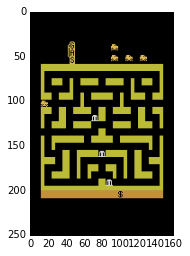

In [9]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [10]:
n_actions = atari.action_space.n
observation_shape = (None,) + atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [11]:
observation_shape

(None, 250, 160, 3)

In [12]:
del atari

# Agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
   
   
We are going to build something of this shape:

(one can assume that the 'time' goes from left to right, inputs are at the bottom and outputs go to the top)



![window_dqn_scheme](http://s32.postimg.org/yy5q3wadx/window_dqn.png)
  




##### Agent observations

* Here you define where observations (game images) appear in the network

In [13]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer, Pool2DLayer

In [14]:
#image observation at current tick goes here
observation_layer = InputLayer(observation_shape, name="images input")


#reshape to [batch, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))
observation_reshape = Pool2DLayer(observation_reshape, pool_size=(2,2))

  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


### In this demo
Since we have almost fully observable environment AND we want to keep baseline simple, we shall use no recurrent units.
However, Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.
To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.

One can try to use
 * GRU - `from agentnet.memory import GRUMemoryLayer`
 * RNN - `from agentnet.memory import RNNCell`
 * any custom lasagne layers that compute new memory states


In [15]:
#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation


window_size = 5


#prev state input
prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")


#our window
window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")



memory_dict = {window:prev_window}

##### Neural network body
Our strategy, again:
 * take pixel-wise maximum over the window
 * apply some layers
 * use output layer to predict Q-values(see next)

In [16]:
from lasagne.layers import DropoutLayer,DenseLayer, ExpressionLayer
#you may use any other lasagne layers, including convolutions, batch_norms, maxout, etc

#pixel-wise maximum over the temporal window (to avoid flickering)
window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])



#a simple lasagne network (try replacing with any other lasagne network and see what works best)    
nn = lasagne.layers.Conv2DLayer(window_max, num_filters=16, filter_size=(8, 8), stride=(4, 4))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.BatchNormLayer(nn)

#WARNING! if your network is computing too slowly, try decreasing the amount of neurons

##### Agent policy and action picking
* Since we are training a deep Q-network, we need it to predict Q-values and take actions.
* Hence we define a lasagne layer that is used for action output

* To pick actions, we use an epsilon-greedy resolver
  * Note that resolver outputs particular action IDs and not probabilities.
  * These actions are than sent into the environment

In [17]:
#q_eval
q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")

#resolver
from agentnet.resolver import EpsilonGreedyResolver
resolver = EpsilonGreedyResolver(q_eval,name="resolver")

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [18]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)


In [19]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 QEvaluator.W,
 QEvaluator.b]

# Agent step function
* computes action and next state given observation and prev state
* written in a generic way to support any recurrences, windows, LTMs, etc

In [20]:
#compile theano graph for one step decision making
applier_fun = agent.get_react_function()

#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype='float32') 
                         for mem in agent.agent_states]
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [21]:
from agentnet.experiments.openai_gym.pool import GamePool

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-06-06 11:35:22,478] Making new env: BankHeist-v0


In [22]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(step,50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['DOWN' 'DOWN' 'DOWNLEFTFIRE' 'DOWN' 'DOWN']]
CPU times: user 180 ms, sys: 100 ms, total: 280 ms
Wall time: 579 ms


# Experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [23]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.state_variables)

In [24]:
def prepare(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(step,n_steps=n_steps)
        
    #load them into experience replay environment
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
    
prepare(env,pool,n_steps=replay_seq_len)
    

In [25]:
def update_pool(env, pool, n_steps=100, pool_size=1000):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(step,n_steps=n_steps)
    
    #observations
    obs = env.observations[0].get_value()
    observation_tensor = np.concatenate((obs, observation_tensor), axis=0)
    
    #actions
    act = env.actions[0].get_value()
    action_tensor = np.concatenate((act, action_tensor), axis=0)
    
    #rewards
    rwd = env.rewards.get_value()
    reward_tensor = np.concatenate((rwd, reward_tensor), axis=0)
    
    #is_alives
    is_a = env.is_alive.get_value()
    is_alive_tensor = np.concatenate((is_a, is_alive_tensor), axis=0)
    
    #prev memories
    prev_mem = env.preceding_agent_memories[0].get_value()
    preceding_memory_states = np.concatenate((prev_mem, preceding_memory_states[0]), axis=0)
    
    if observation_tensor.shape[0] > pool_size:
        observation_tensor = observation_tensor[-pool_size:]
        action_tensor = action_tensor[-pool_size:]
        reward_tensor = reward_tensor[-pool_size:]
        is_alive_tensor = is_alive_tensor[-pool_size:]
        preceding_memory_states = preceding_memory_states[-pool_size:]
    
    #load everything into the environmnet
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[preceding_memory_states])

In [26]:
#load first  sessions
update_pool(env, pool, replay_seq_len, pool_size=pool_size)

In [27]:
print env.preceding_agent_memories[0].get_value().shape

(2, 5, 3, 125, 80)


In [28]:
#create first batch environment
batch_env = env.sample_session_batch(replay_batch_size)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [29]:
#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    batch_env,
    session_length=replay_seq_len,
    batch_size=replay_batch_size,
    optimize_experience_replay=True,
    unroll_scan = False,
)


#The "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - observation sequences - whatever agent recieved at observation input(s) on each tick
#third - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now


/home/jheuristic/yozhik/AgentNet/agentnet/agent/recurrence.py:313: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened"
/home/jheuristic/yozhik/AgentNet/agentnet/agent/mdp_agent.py:386: UserWarning: return_automatic_updates useful when and only when unroll_scan == False
  warn("return_automatic_updates useful when and only when unroll_scan == False")


In [30]:
#needed if we use unroll_scan = False in agent.get_sessions() function
auto = agent.get_automatic_updates()

# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [31]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning_n_step

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later




#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = batch_env.rewards
#For SpaceInvaders, however, not scaling rewards is at least working


elwise_mse_loss = qlearning_n_step.get_elementwise_objective(qvalues_seq,
                                                        batch_env.actions[0],
                                                        scaled_reward_seq,
                                                        batch_env.is_alive,
                                                        n_steps=10,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / batch_env.is_alive.sum()

In [32]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [33]:
loss = mse_loss + reg_l2

In [34]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [35]:
#mean session reward
mean_session_reward = batch_env.rewards.sum(axis=1).mean()

# Compile train and evaluation functions

In [ ]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates+auto)

In [31]:
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward],updates=auto)

# Session visualization tools

Just a helper function that draws current game images.

In [32]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.games[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

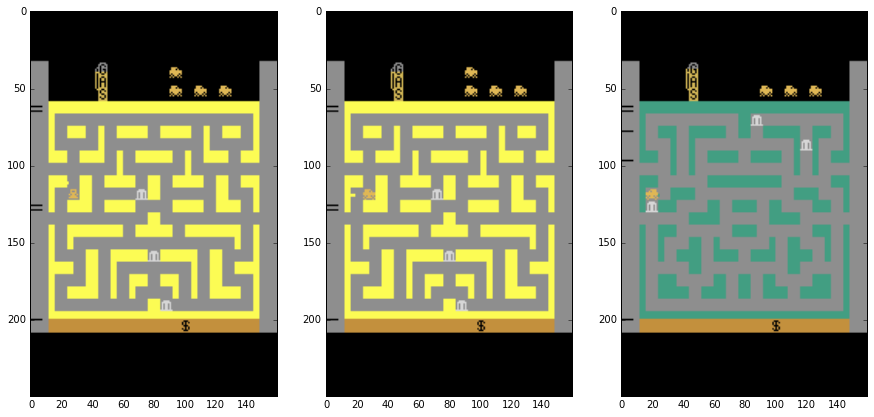

In [33]:
#visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [34]:
from agentnet.display import Metrics
score_log = Metrics()

In [35]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [36]:
batch_env = env.sample_session_batch(replay_batch_size)

In [39]:
def checkpoint(name):
    params = lasagne.layers.get_all_param_values(resolver)
    pickle.dump(params, open(name, 'wb'))

epoch 100,loss 2.30351, epsilon 0.45718, rewards: ( e-greedy 0.65125, greedy 0.66468) 
rec 2.219 reg 0.084
Learning curves:


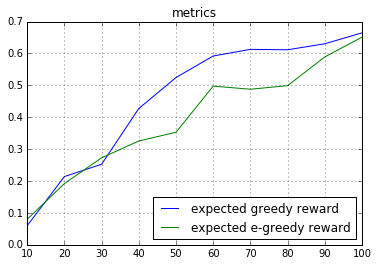

Random session examples


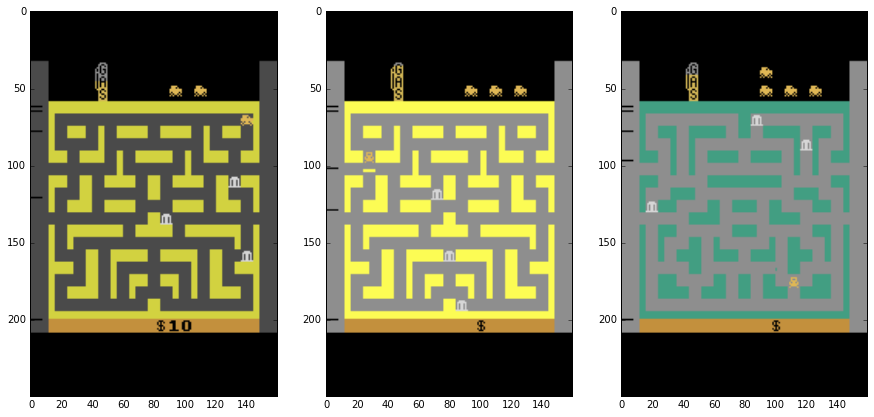

In [ ]:
%%time

n_epochs = 100
#25k may take hours to train.
#consider interrupt early.



for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len,pool_size)
    #print np.shape(env.observations[0].get_value())
    batch_env = env.sample_session_batch(replay_batch_size)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    #print 'I am here!'
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len,pool_size)
        batch_env = env.sample_session_batch(replay_batch_size)
        
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len,pool_size)
        #batch_env = env.sample_session_batch(replay_batch_size)
        
        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
        
        checkpoint('params/BankHeist-v0_' + str(epoch_counter))
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==0:
        
        save_path = 'videos/BankHeist-v0_' + str(epoch_counter)

        subm_env = gym.make(GAME_TITLE)

        #starting monitor. This setup does not write videos
        subm_env.monitor.start(save_path,lambda i: False,force=True)

        #this setup does
        #subm_env.monitor.start(save_path,force=True)

        rws = []

        for i_episode in xrange(250):

            #initial observation
            observation = subm_env.reset()
            #initial memory
            prev_memories = "zeros"

            s_reward =0.
            t = 0
            while True:

                action,new_memories = step([observation],prev_memories,batch_size=1)
                observation, reward, done, info = subm_env.step(action[0])

                s_reward += reward

                prev_memories = new_memories
                if done:
                    print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
                    rws.append(s_reward)
                    break
                t+=1

        subm_env.monitor.close()

        rws = np.array(rws)
        np.savez(open('rws4hist_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

## Record videos

In [43]:
save_path = 'videos/BankHeist-v0_' + str(epoch_counter-1)

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
subm_env.monitor.start(save_path,force=True)

rws = []

for i_episode in xrange(10):

    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"

    s_reward =0.
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])

        s_reward += reward

        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
            rws.append(s_reward)
            break
        t+=1

subm_env.monitor.close()

rws = np.array(rws)
np.savez(open('rws4hist_'+str(epoch_counter-1)+'.npz', 'wb'), rws=rws)

[2016-06-02 17:58:26,407] Making new env: BankHeist-v0
[2016-06-02 17:58:26,443] Creating monitor directory videos/BankHeist-v0_510
[2016-06-02 17:58:26,489] Starting new video recorder writing to /Users/mariewelt/Documents/Pacman/videos/BankHeist-v0_510/openaigym.video.2.4278.video000000.mp4
[2016-06-02 17:58:34,418] Starting new video recorder writing to /Users/mariewelt/Documents/Pacman/videos/BankHeist-v0_510/openaigym.video.2.4278.video000001.mp4


Episode finished after 1275 timesteps, rw = 20.0
Episode finished after 673 timesteps, rw = 0.0
Episode finished after 750 timesteps, rw = 0.0
Episode finished after 661 timesteps, rw = 10.0
Episode finished after 863 timesteps, rw = 0.0
Episode finished after 854 timesteps, rw = 10.0
Episode finished after 749 timesteps, rw = 0.0


[2016-06-02 17:59:03,002] Starting new video recorder writing to /Users/mariewelt/Documents/Pacman/videos/BankHeist-v0_510/openaigym.video.2.4278.video000008.mp4


Episode finished after 1181 timesteps, rw = 20.0
Episode finished after 1017 timesteps, rw = 0.0


[2016-06-02 17:59:12,493] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/mariewelt/Documents/Pacman/videos/BankHeist-v0_510')


Episode finished after 737 timesteps, rw = 10.0


(array([ 5.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

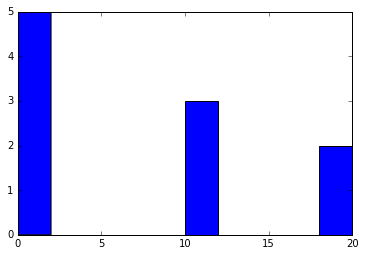

In [44]:
plt.hist(rws)

# Evaluating results
 * Here we plot learning curves and sample testimonials

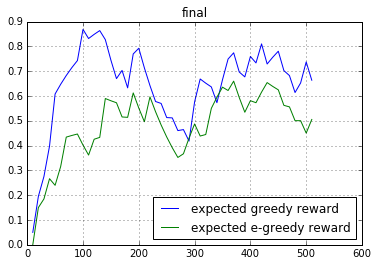

In [45]:
score_log.plot("final")

Random session examples


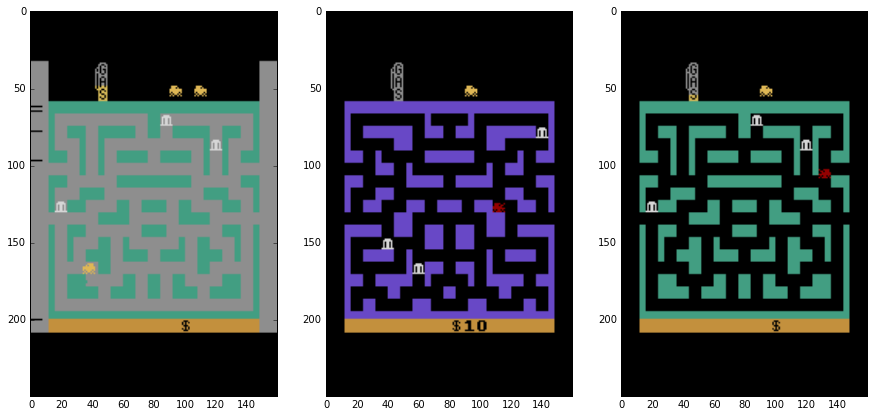

In [46]:
print("Random session examples")
display_sessions()


# Save learning curves

In [74]:
import pickle

lc = {'e-greedy':score_log['expected e-greedy reward'], 'greedy':score_log['expected greedy reward']}

with open(str(epoch_counter-1)+'iter_lc.pickle', 'wb') as handle:
    lc = pickle.dump(lc, handle)

# Submission
Here we simply run the OpenAI gym submission code and view scores

In [96]:
resolver.epsilon.set_value(0)

In [99]:
save_path = '/tmp/AgentNet-simplenet-MsPacman-v0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(200):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

INFO:gym.envs.registration:Making new env: MsPacman-v0
[2016-05-26 14:32:34,089] Making new env: MsPacman-v0
INFO:gym.monitoring.monitor:Clearing 2 monitor files from previous run (because force=True was provided)
[2016-05-26 14:32:34,109] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 911 timesteps
Episode finished after 1163 timesteps
Episode finished after 905 timesteps
Episode finished after 1126 timesteps
Episode finished after 1081 timesteps
Episode finished after 1006 timesteps
Episode finished after 788 timesteps
Episode finished after 892 timesteps
Episode finished after 853 timesteps
Episode finished after 981 timesteps
Episode finished after 835 timesteps
Episode finished after 1329 timesteps
Episode finished after 1032 timesteps
Episode finished after 829 timesteps
Episode finished after 1010 timesteps
Episode finished after 802 timesteps
Episode finished after 1030 timesteps
Episode finished after 707 timesteps
Episode finished after 1051 timesteps
Episode finished after 1604 timesteps
Episode finished after 884 timesteps
Episode finished after 1232 timesteps
Episode finished after 1179 timesteps
Episode finished after 1308 timesteps
Episode finished after 1049 timesteps
Episode finished after 1468 timesteps
Episode finished after 

INFO:gym.monitoring.monitor:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-MsPacman-v0-Recording0')
[2016-05-26 14:45:11,171] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-MsPacman-v0-Recording0')


In [109]:
[monitor.close() for monitor in gym.monitoring._open_monitors()]

INFO:gym.monitoring.monitor:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-pacmanv0-Recording0')
[2016-05-26 14:52:08,502] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-pacmanv0-Recording0')
INFO:gym.monitoring.monitor:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-MsPacman-v0-Recording0')
[2016-05-26 14:52:08,503] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-MsPacman-v0-Recording0')


[None, None]

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. agent-critic), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper

 
__Good luck!__

In [79]:
gym.upload?